## Import Dependencies
*****

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


import numpy as np
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

# DATA LOADING

## Loading the train and test data
*********

In [2]:
df_train=pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")


# DATA EXPLORATION
******************

In [3]:
print("Label in Train set {} with count are \n{}".format(set(df_train['income_level']),df_train['income_level'].value_counts()))
print("Label in Test set {} with count are \n{}".format(set(df_test['income_level']),df_train['income_level'].value_counts()))

Label in Train set {-50000, 50000} with count are 
-50000    187141
 50000     12382
Name: income_level, dtype: int64
Label in Test set {' 50000+.', '-50000'} with count are 
-50000    187141
 50000     12382
Name: income_level, dtype: int64



*******
 187141 persons have salary less than 50000.(majority class)<br>
 12382 persons have salary more than 50000.(minority class)
 
 Total ~94% data is of majority class
*******

Creating encoding for Train and test target variables-<br>
a) 0 for person having income less than 50000<br>
b) 1 for persons having income more than 50000<br>
**********

In [4]:
df_train['income_level']=df_train['income_level'].apply(lambda x: 0 if x==-50000 else 1)
df_test['income_level']=df_test['income_level'].apply(lambda x: 0 if x=='-50000' else 1)
print("Percentage of majority class is {}".format((df_train['income_level'].value_counts()[0]/df_train.shape[0]) *100))

Percentage of majority class is 93.79419916500854


******
<strong>Now we will separate the numerical and Categorical feature</strong>
******


<i>Understanding the variables using histogram</i>
    - The plot has data for people aged between 0-90.
    - It is less likely that people with age less than 20 will earn >50000
    - Hence we can bin this age group.

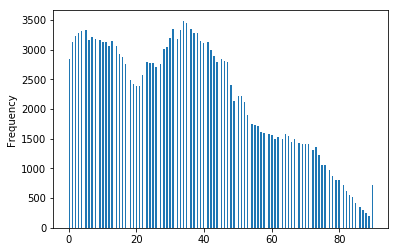

In [5]:
df_train['age'].plot(kind="hist",bins=200)

<i>Creating scatter plot for multiple numerical variable with the dependent variable</i>
    - As it is clearly evident that people with age group 20-65 and earning a
        wage per hour as 4000-5000 are more likely of having income level as 1
    

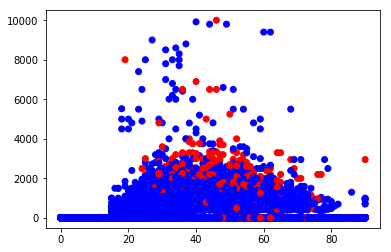

In [6]:
#Blue for income less than 50k and red for income more than 50k
colors={0:'b',1:'r'}
plt.scatter(df_train["age"],df_train["wage_per_hour"],c=df_train['income_level'].apply(lambda x: colors[x]))
#plt.scatter(df_train["age"],df_train["wage_per_hour"],color='red', label='1')
plt.show()

<i>Understanding how categorical variable are plotted</i>
    - Lets say Not in Universe are those employee who didn't provided the correct details due to some reason.
    - Not much information can be tracked from the graph as only two classes have more value in this case its better to combine levels having value less than 5%.
    

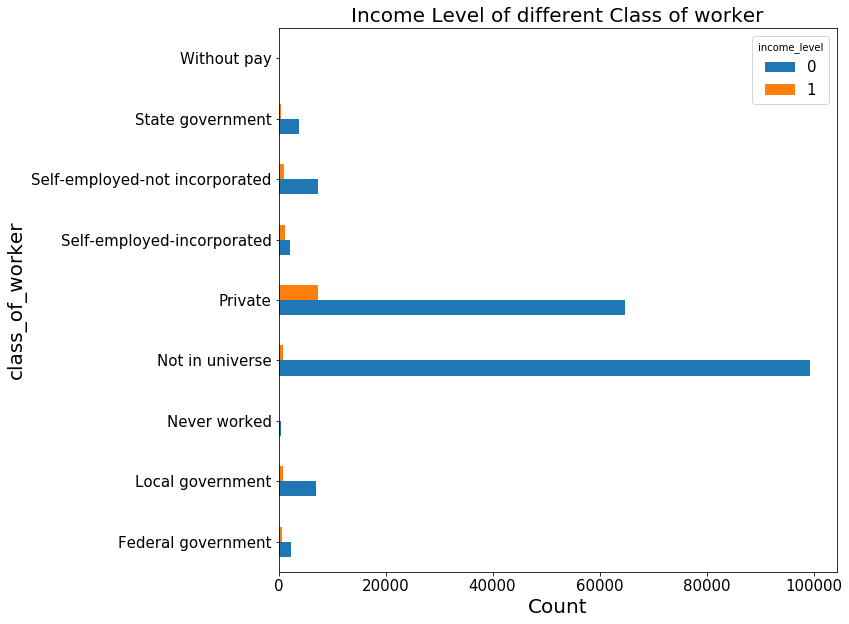

In [7]:
d=pd.crosstab(index=df_train["class_of_worker"], columns=df_train["income_level"])

fig,ax=plt.subplots(1,1,figsize=(10,10))

d.plot(kind="barh",ax=ax,stacked=False,fontsize=15).legend(fontsize='15',title='income_level')

title='Income Level of different Class of worker'
ax.set_title(title,fontsize= 20,color='Black')

plt.xlabel('Count',fontsize= 20,color='Black')
plt.ylabel('class_of_worker',fontsize= 20,color='Black')

plt.show()
fig.tight_layout()

<i>Understanding how income is affected by education level </i>
    - As we can see students have less chances for having income more than 50k
    - On the other hand Bachelor's degree or above has the more number of persons with salary more than 50k

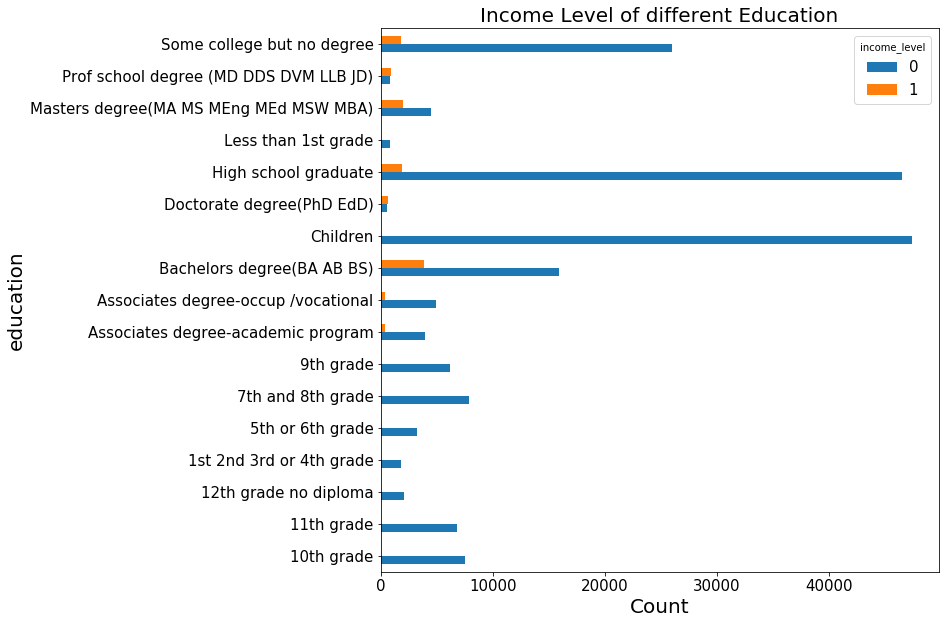

In [8]:
d=pd.crosstab(index=df_train["education"], columns=df_train["income_level"])

fig,ax=plt.subplots(1,1,figsize=(10,10))

d.plot(kind="barh",ax=ax,stacked=False,fontsize=15).legend(fontsize='15',title='income_level')

title='Income Level of different Education'
ax.set_title(title,fontsize= 20,color='Black')

plt.xlabel('Count',fontsize= 20,color='Black')
plt.ylabel('education',fontsize= 20,color='Black')

plt.show()
fig.tight_layout()

# DATA CLEANING
***************

In [9]:
num_df=df_train[['age','wage_per_hour','capital_gains','capital_losses','dividend_from_Stocks','num_person_Worked_employer','business_or_self_employed','veterans_benefits','weeks_worked_in_year','year']]
cat_df=df_train[['class_of_worker','industry_code', 'occupation_code','education','enrolled_in_edu_inst_lastwk','marital_status','major_industry_code','major_occupation_code','race','hispanic_origin','sex','member_of_labor_union','migration_msa','migration_reg','migration_within_reg','migration_sunbelt','reason_for_unemployment','full_parttime_employment_stat','tax_filer_status','region_of_previous_residence','state_of_previous_residence','d_household_family_stat','d_household_summary','live_1_year_ago','family_members_under_18','country_father','country_mother','country_self','citizenship','fill_questionnaire_veteran_admin']]

<i>Removing correlated variables</i>
    - In case of numerical variable we have to remove the variable which are highly corelated.
    - In this removing 'weeks_worked_in_year' for now.

In [10]:
correlatio_table=num_df.corr()
num_df.corr().style.format("{:.5}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,age,wage_per_hour,capital_gains,capital_losses,dividend_from_Stocks,num_person_Worked_employer,business_or_self_employed,veterans_benefits,weeks_worked_in_year,year
age,1.0,0.036938,0.05359,0.063351,0.10498,0.14089,-0.0022655,0.67484,0.20618,0.0044135
wage_per_hour,0.036938,1.0,-0.001082,0.010993,-0.005731,0.19154,0.054051,0.11309,0.19569,0.0022829
capital_gains,0.05359,-0.001082,1.0,-0.0127,0.13148,0.058015,0.015048,0.05153,0.083549,0.0052434
capital_losses,0.063351,0.010993,-0.0127,1.0,0.042427,0.084255,0.024116,0.075391,0.10076,9.5726e-05
dividend_from_Stocks,0.10498,-0.005731,0.13148,0.042427,1.0,0.0072063,-0.0048846,0.054585,0.013823,0.0019127
num_person_Worked_employer,0.14089,0.19154,0.058015,0.084255,0.0072063,1.0,0.24055,0.46333,0.7473,0.018774
business_or_self_employed,-0.0022655,0.054051,0.015048,0.024116,-0.0048846,0.24055,1.0,0.17745,0.26587,0.0073771
veterans_benefits,0.67484,0.11309,0.05153,0.075391,0.054585,0.46333,0.17745,1.0,0.53228,0.0031223
weeks_worked_in_year,0.20618,0.19569,0.083549,0.10076,0.013823,0.7473,0.26587,0.53228,1.0,0.0052521
year,0.0044135,0.0022829,0.0052434,9.5726e-05,0.0019127,0.018774,0.0073771,0.0031223,0.0052521,1.0



<i>Percentage of null values in each columns</i>
    - Removing column with null value ~50% as they are not having much information(In data science most of the time apart from values we have to focus on intuition from variables also)
    - Most of the numerical columns are complete
    - The categorical column has more number of missing data.
    - Check for null values in test data also 

In [11]:
count=0
null_values=pd.DataFrame()
for each in df_train.columns:
    
    percentage=(df_train.loc[df_train[each].isnull()==True].shape[0]/df_train.shape[0])*100
    data={"Column Name":each,"Percentage":percentage}
    null_values=null_values.append(data,ignore_index=True)
    count+=1
null_values.sort_values('Percentage',ascending=False,inplace=True)
null_values.head(10)

,Column Name,Percentage
24,migration_msa,49.967172
25,migration_reg,49.967172
26,migration_within_reg,49.967172
28,migration_sunbelt,49.967172
31,country_father,3.364524
32,country_mother,3.066814
33,country_self,1.700556
11,hispanic_origin,0.438045
21,state_of_previous_residence,0.354846
29,num_person_Worked_employer,0.000000


<i> Imputing missing data and dropping the column with more percentage of null values and correlation</i>
    - Apart from column with null ~50% some other column have null less than 5%.
    - Imputing column with 'Unavailable' as null values are there in categorical column.
    - Dropping ['migration_msa','migration_reg','migration_within_reg','migration_sunbelt','weeks_worked_in_year'] columns

In [12]:
df_train.drop(['migration_msa','migration_reg','migration_within_reg','migration_sunbelt','weeks_worked_in_year'],axis=1,inplace=True)
df_test.drop(['migration_msa','migration_reg','migration_within_reg','migration_sunbelt','weeks_worked_in_year'],axis=1,inplace=True)
df_train.fillna('Unavailable',inplace=True)
df_test.fillna('Unavailable',inplace=True)
num_df.drop(['weeks_worked_in_year'],axis=1,inplace=True)
cat_df.drop(['migration_msa','migration_reg','migration_within_reg','migration_sunbelt'],axis=1,inplace=True)


# DATA MANIPULATION
****************

<i>Combining the factor levels</i>
    - In previous analysis we saw that in categorical column several columns have low frequencies for few levels.
    - So combining the factor levels and representing it with 'Other'.
    - Combine those levels which have percentage distribution less than 5%.
    - Doing it for train and test set both.

In [13]:
def CombineLevels(x):
    if x in list(LabelstoCombine):
        return "Other"
    else:
        return x

In [14]:
for each in cat_df:
    name=each
    percentageDistribution=df_train.groupby(name).size()*100/df_train.shape[0]
    #print(percentageDistribution)
    LabelstoCombine=percentageDistribution[percentageDistribution<5].index
    df_train[name]=df_train[name].apply(CombineLevels)
    #print(name)
    #print("*****************************************************")
    
for each in cat_df:
    name=each
    percentageDistribution=df_test.groupby(name).size()*100/df_test.shape[0]
    #print(percentageDistribution)
    LabelstoCombine=percentageDistribution[percentageDistribution<5].index
    df_test[name]=df_test[name].apply(CombineLevels)
    #print(name)
    #print("*****************************************************")

<i>Checking the number of levels in train and test set</i>
    - It is necessary to have same factor levels in both the train and test data.
    - Otherwise some manual mapping needs to be created.

In [15]:
flag=0
for each in cat_df:
    name=each
    
    if(df_train[name].value_counts().count()!=df_test[name].value_counts().count()):
        print("Different levels Count")
        flag=1
        break
    else:
        pass
if(flag==0):
    print("Same level Counts")

Same level Counts


<i>Binning the numerical data</i>
    - In most of the numerical columns major number of fields are 0 so bining those column at "Zero" and "More than Zero"
    - Age we can bin at (0-30],(30-65],(65,90]

In [16]:
bins=[0,30,65,90]
age_levels={'(0, 30]':'young','(30, 65]':'adult','(65, 90]':'old'}

def replace_age(x):
    return age_levels[x]

#For Train Data
df_train['age']=pd.cut(df_train['age'], bins)
df_train['age']=df_train['age'].apply(lambda x: replace_age(str(x)))
df_train['wage_per_hour']=df_train['wage_per_hour'].apply(lambda x: int(0) if x==0 else int(1))
df_train['capital_gains']=df_train['capital_gains'].apply(lambda x: int(0) if x==0 else int(1))
df_train['capital_losses']=df_train['capital_losses'].apply(lambda x: int(0) if x==0 else int(1))
df_train['dividend_from_Stocks']=df_train['dividend_from_Stocks'].apply(lambda x: int(0) if x==0 else int(1))

#For Test Data
df_test['age']=pd.cut(df_test['age'], bins)
df_test['age']=df_test['age'].apply(lambda x:replace_age(str(x)))
df_test['wage_per_hour']=df_test['wage_per_hour'].apply(lambda x: int(0) if x==0 else int(1))
df_test['capital_gains']=df_test['capital_gains'].apply(lambda x: int(0) if x==0 else int(1))
df_test['capital_losses']=df_test['capital_losses'].apply(lambda x: int(0) if x==0 else int(1))
df_test['dividend_from_Stocks']=df_test['dividend_from_Stocks'].apply(lambda x: int(0) if x==0 else int(1))

# Feature Conversion
******************

<i> Converting the column into features for model training</i>
    - It is necessary to convert all the text and strings into number so that model can take it as input.

In [17]:
import sklearn
from sklearn import preprocessing

lb_make = preprocessing.LabelEncoder()
#Train Data
for each in df_train.columns:
    df_train[each] = lb_make.fit_transform(list(df_train[each].values))

#Test Data
for each in df_test.columns:
    df_test[each] = lb_make.fit_transform(list(df_test[each].values))

# MACHINE LEARNING
***************

<i>Getting the important of features</i>
    - In case of categorical features we can use chi2 for determining the importance of feature
    - Its not always necessary that we select the best feature given by a particular measure. Some features are selected based on intuition also or other measure. 

In [18]:
from sklearn.feature_selection import chi2
chi_square_score,pvalue=chi2(df_train[list(df_train.columns)[:-1]],df_train['income_level'])
chi_square=pd.DataFrame(chi_square_score,list(df_train.columns)[:-1])
chi_square.columns=['chi_square']
chi_square.sort_values('chi_square',ascending=False,inplace=True)

Text(0.5,1,'Variances of Categorial features')

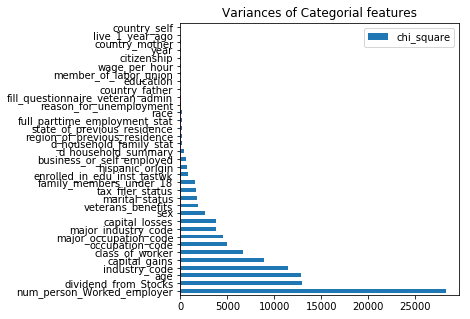

In [19]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
chi_square.plot(kind='barh',ax=ax)
ax.vlines(0.1,ymin=-1,ymax=25,colors='red')
ax.set_title('Variances of Categorial features')

In [20]:
column_with_less_chi_square_score=['country_self','live_1_year_ago']
for each in column_with_less_chi_square_score:
    df_train.drop([each],axis=1,inplace=True)
    df_test.drop([each],axis=1,inplace=True)



In [21]:
#Taking some selected features base on various measures and intuition
predictors=['occupation_code','education','industry_code','d_household_family_stat','age','num_person_Worked_employer'
           ,'tax_filer_status','marital_status','veterans_benefits','sex','full_parttime_employment_stat','capital_gains','capital_losses',
           'hispanic_origin','country_father','country_mother','race','dividend_from_Stocks','business_or_self_employed']

target='income_level'

# Sampling
*****************

<i>Handling Class Imbalance</i>
    - The minority class is oversampled using Synthetic minority Oversampling Technique(Smote)
    - GridSearchCv used for handling the parameter optimizing in Smote
    

Best parameters : {'smote__ratio': 0.2}


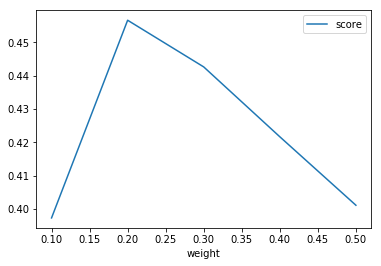

In [22]:
from collections import Counter
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

pipe = make_pipeline(
    SMOTE(ratio=0.23),
    LogisticRegression()
)

weights = np.linspace(.1,.5,5)

gsc = GridSearchCV(
    estimator=pipe,
    param_grid={
        
        #'class_weight': [{0: int(num_neg), 1: int(num_neg * w) } for w in weights]
        'smote__ratio':weights
    },
    scoring='f1',
    cv=3
)
grid_result = gsc.fit(df_train[predictors].values,df_train[target])

print("Best parameters : %s" % grid_result.best_params_)

# Plot the weights vs f1 score
dataz = pd.DataFrame({ 'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
dataz.plot(x='weight')

In [23]:
from imblearn.over_sampling import SMOTE

#Ratio decided using GridSearchCV
sm = SMOTE(ratio=.2,random_state=12,k_neighbors=3)
x_train_res, y_train_res = sm.fit_sample(df_train[predictors],df_train[target])

print('Sampled dataset shape {}'.format(Counter(y_train_res)))

x_train_res=pd.DataFrame(x_train_res)
x_train_res.columns=predictors
y_train_res=pd.DataFrame(y_train_res)
y_train_res.columns=[target]

X_test=df_test[predictors]
Y_test=df_test[target]

Sampled dataset shape Counter({0: 187141, 1: 37428})


# Training the Model
*****************

<i>Model Building</i>
    - In Imbalanced data set model accuracy is not the only metric for measurement of model performance.
    - For checking the model performance we will measure the recall and precision of the model.
    - Training a logistic Regression Model.

In [24]:
clf = LogisticRegression(random_state=12,class_weight='balanced')
clf.fit(x_train_res,y_train_res)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=12,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [25]:
from sklearn.metrics import confusion_matrix
Y_pred=clf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(Y_test,Y_pred).ravel()
print("Confusion Matrix\n {}".format(confusion_matrix(Y_test,Y_pred)))


print("Accuracy is {}".format((tp+tn)*100/(tp+fp+fn+tn)))

print(classification_report(Y_test,Y_pred))

Confusion Matrix
 [[76660 16916]
 [ 1091  5095]]
Accuracy is 81.9500410978128
             precision    recall  f1-score   support

          0       0.99      0.82      0.89     93576
          1       0.23      0.82      0.36      6186

avg / total       0.94      0.82      0.86     99762



********************
<i>The testing set has 6186 examples with income>50k, and out of these, the model was able to identify 5095 correctly. It also identified 16916 examples in this class wrongly, and 1091 as belonging to majority class(<50k).

Based on model the factors most affecting the annual incomes are-
occupation_code,education,industry_code,weeks_worked_in_year,d_household_family_stats,age,num_person_Worked_employer,
tax_filer_status,marital_status,veterans_benefits,sex,full_parttime_employment_stat,capital_gains,
capital_losses,hispanic_origin,country_father,country_mother,race,dividend_from_Stocks,business_or_self_employed
</i>

# Conclusion
********************

This machine learning model was able to predict the annual income of persons with 20 parameters with an accuracy of ~82%.
The model will perform better if the training data is updated .The model can continously learn from changing data in training set to adapt to new parameters.
Thus improving accuracy and other metrics